<a href="https://colab.research.google.com/github/MattHodgman/ProteoHist/blob/main/protein_expression_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression model to predict protein expression in tumor and normal tissue

## Set up and functions

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import pickle

In [ ]:
# paths and functions
tumor_path = '/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/tumor/FEATURES_DIRECTORY/h5_files/'
normal_path = '/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/normal/FEATURES_DIRECTORY/h5_files/'
both_path = '/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/both/FEATURES_DIRECTORY/h5_files/'


def make_df(path, group):
  files = os.listdir(path)
  ids = pd.DataFrame([id[:-3] for id in files], columns=['id'])
  df_ids = pd.DataFrame(ids)
  df_ids[['sample', 'id']] = df_ids['id'].str.rsplit('-', 1, expand=True)
  df_ids['file'] = df_ids['sample'] + '-' + df_ids['id'] + '.h5'
  df_ids['group'] = group

  return df_ids


def read_features(path, file_name, class_labels):
  f = h5py.File(f'{path}/{file_name}')
  x = np.array(f['features'])

  coords = np.array(f['coords'])
  x = np.hstack((np.full((x.shape[0], len(class_labels)), class_labels), x))
  x = np.hstack((coords, x))
  file_name_n_patches = [file_name, x.shape[0]]

  return x, file_name_n_patches


def get_X(df, targets):
  X = np.empty((0, 1024 + 2 + len(targets))) # 2 for the patch coords
  file_patch_dict = {}
  file_patch_count = []

  for index, row in df.iterrows():
    group = row['group']
    path = f'/content/drive/MyDrive/BIOINF_590/Data/Images/clam_output/{group}/FEATURES_DIRECTORY/h5_files'
    x, file_name_n_patches = read_features(path, row['file'], list(row[targets].values))
    file_patch_dict[file_name_n_patches[0]] = [X.shape[0], X.shape[0]+file_name_n_patches[1]-1]
    file_patch_count.append(file_name_n_patches)
    X = np.vstack((X, x))

  return X, file_patch_dict, file_patch_count


def format_protein_expression(df, n_proteins):
  df = df.sort_values('p')
  proteins = df[:n_proteins]['gene'].values.tolist()
  df = df[:n_proteins].T.reset_index()
  new_header = df.iloc[0] 
  df = df[2:] # remove gene and p-value rows
  df.columns = new_header
  df = df.rename(columns={'gene' : 'idx'})
  
  return df, proteins


def get_proteins(df, proteins):
  df = df[df['gene'].isin(proteins)].T.reset_index()
  new_header = df.iloc[0]
  df = df[2:] # remove gene and p-value rows
  df.columns = new_header
  df = df.rename(columns={'gene' : 'idx'})

  return df


def get_patch_values(all_file_patch_counts, coords):
  patch_values = []
  i = 0
  for x in all_file_patch_counts:
    file_name = x[0] # get file name
    n = x[1] # get number of patches
    patch_coords = coords[i:i+n,:]
    i = i + n

    for patch in patch_coords:
      patch_values.append([file_name, patch[0], patch[1]])

  return patch_values


def write(patch_values, y_preds, target, file_name):
  df_results = pd.DataFrame(np.hstack((np.array(patch_values), y_preds)), columns=['file_name', 'x', 'y', target])
  df_results.to_csv(f'/content/drive/MyDrive/BIOINF_590/Data/PredictedPatchExpression/{file_name}.csv', index=False)


def load_batch(df, targets):
  X, file_patch_dict, file_patch_count = get_X(df, targets)

  # extract patch coords
  coords = X[:,:2]
  X = np.delete(X, [0,1], axis=1)

  # extract class label
  y = X[:,:len(targets)]
  X = np.delete(X, list(range(len(targets))), axis=1)

  return X, y, coords, file_patch_dict, file_patch_count

## Load, format, preprocess data

### Prep metadata

In [ ]:
# get metadata
df = pd.concat([make_df(normal_path, 'normal'), make_df(tumor_path, 'tumor'), make_df(both_path, 'both')])
df['class'] = df['group'].map({'normal' : 0, 'tumor' : 1, 'both' : 2})

# get id mapping
df_ids = pd.read_excel('/content/drive/MyDrive/BIOINF_590/Data/Metadata/mmc1.xlsx')
df_ids['Proteomics_Tumor_Normal'].unique()
df_ids['Proteomics_Tumor_Normal'] = df_ids['Proteomics_Tumor_Normal'].map({'Tumor' : 'tumor', 'Adjacent_normal' : 'normal', 'Myometrium_normal' : 'normal', 'Enriched_normal' : 'normal'})

# combine
df = pd.merge(df, 
         df_ids[['Proteomics_Participant_ID','idx', 'Proteomics_Tumor_Normal']], 
         left_on='sample', 
         right_on='Proteomics_Participant_ID')

df = df[(df['group'] == df['Proteomics_Tumor_Normal']) | ((df['group'] == 'both') & (df['Proteomics_Tumor_Normal'] == 'tumor'))]
df = df.drop(['Proteomics_Participant_ID','Proteomics_Tumor_Normal'], axis=1)

# get proteomics data
df_tumor_high = pd.read_csv('/content/drive/MyDrive/BIOINF_590/Data/ExpressionData/ucec_proteome_tumor_high_p.txt', delimiter='\t')
df_tumor_low = pd.read_csv('/content/drive/MyDrive/BIOINF_590/Data/ExpressionData/ucec_proteome_tumor_low_p.txt', delimiter='\t')

# get top 5 significant proteins for both low and high expression
df_tumor_high_top, high_proteins = format_protein_expression(df_tumor_high, 5)
df_tumor_low_top, low_proteins = format_protein_expression(df_tumor_low, 5)

# get proteomics data of specific proteins with FDA approved drugs
df_druggable_proteins = get_proteins(df_tumor_high, ['CDK12', 'SMARCA4', 'PML'])

# get protein expression data for prognostic protein
df_prognostic_protein = get_proteins(df_tumor_high, ['ASS1'])

# get proteins with different p-values to test
x = df_tumor_high[df_tumor_high['p'] < 0.5]
x['bin'] = pd.cut(x['p'], 10)
x = x.groupby('bin').sample(10)
x_binned = x.copy()
x = x.drop('bin', axis=1)
proteins = x['gene']
x = x.T.reset_index()
new_header = x.iloc[0]
x = x[2:] # remove gene and p-value rows
x.columns = new_header
x = x.rename(columns={'gene' : 'idx'})
nan_prots = x.columns[x.isna().any()].tolist() # get proteins with nans
for p in nan_prots:
  m = x[p].mean()
  x[p].fillna(value=m, inplace=True) # replace nan with mean

# combine
df = pd.merge(df, df_tumor_high_top, on='idx')
df = pd.merge(df, df_tumor_low_top, on='idx')
df = pd.merge(df, df_druggable_proteins, on='idx')
df = pd.merge(df, df_prognostic_protein, on='idx')
df = pd.merge(df, x, on='idx')

# make balanced subset (without data leakage) for training and testing 
df2 = df[df['group'] != 'both'].groupby('sample').first().reset_index()

<ipython-input-131-a15bb7af1763>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['bin'] = pd.cut(x['p'], 10)


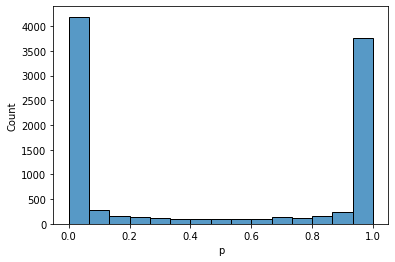

In [ ]:
sns.histplot(data=df_tumor_high, x='p')

### Prep feature and target data for model

In [ ]:
# TRAIN AND TEST MODEL

# get data
X, y, coords, file_patch_dict, file_patch_count = load_batch(df2, proteins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
del X, y, coords, file_patch_dict, file_patch_count

# standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# train and test model
# model = LinearRegression().fit(X_train, y_train)
model = MultiOutputRegressor(LinearRegression()).fit(X_train, y_train)
y_preds = model.predict(X_test)

print(mean_absolute_error(y_test, y_preds), r2_score(y_test, y_preds))
# del X_train, X_test, y_train, y_test, y_preds

0.23347669315176467 0.5858420100372937


In [ ]:
mae = mean_absolute_error(y_test, y_preds, multioutput='raw_values')
r = r2_score(y_test, y_preds, multioutput='raw_values')

cols = list(proteins)
cols.extend(['group'])
foo = df2[cols]
foo = foo.groupby('group').mean()
mean_diff = foo.loc['tumor'] - foo.loc['normal']

res = pd.DataFrame(list(zip(mae, r, proteins, x_binned['p'], mean_diff)), columns=['mae', 'r2', 'protein', 'p-value', 'mean_diff'])

In [ ]:
res.sort_values('r2', ascending=False)

,mae,r2,protein,p-value,mean_diff
27,0.201955,0.791647,UGT8,1.425628e-01,0.252419
9,0.226282,0.783181,RPSA,5.760362e-07,0.336618
4,0.265797,0.773765,UBE2G2,2.175827e-06,0.302618
24,0.112450,0.759498,ATXN10,1.123069e-01,-0.040574
87,0.147822,0.747510,UBTD1,4.046144e-01,0.127892
...,...,...,...,...,...
56,0.305810,0.484020,NDUFB6,2.506248e-01,0.189701
46,0.548302,0.481990,FCN1,2.290129e-01,-0.057108
78,0.152972,0.457010,RNF2,3.513821e-01,0.167140
63,0.197961,0.440527,BLZF1,3.274573e-01,-0.129702


[Text(0, 0.5, 'mean absolute error'),
 Text(0.5, 0, 'difference between mean group expression'),
 Text(0.5, 1.0, 'Correlation between mean difference and mean absolute error')]

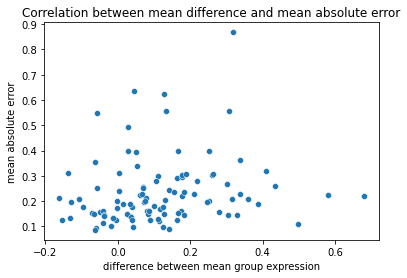

In [ ]:
sns.scatterplot(data=res, x='mean_diff', y='mae').set(xlabel='difference between mean group expression', ylabel='mean absolute error', title='Correlation between mean difference and mean absolute error')

In [ ]:
# RUN MODEL ON ALL SLIDES

dfs = np.array_split(df, 30) # split data into pieces
all_y_preds = []
all_coords = []
all_file_patch_dicts = []
all_file_patch_counts = []

# iteratively fit
for d in dfs:
  X, y, coords, file_patch_dict, file_patch_count = load_batch(d, ['RTKN'])
  X = scaler.transform(X)
  y_preds = model.predict(X)

  del X, y
  all_y_preds.append(y_preds)
  all_coords.append(coords)
  all_file_patch_counts.extend(file_patch_count)

all_y_preds = np.vstack(all_y_preds)
all_coords = np.vstack(all_coords)

In [ ]:
# format and write results
patch_values = get_patch_values(all_file_patch_counts, all_coords)
write(patch_values, all_y_preds, 'RTKN', 'all_slides_RTKN')